# The introductory computer exercise using Python and the SUND toolbox

This version of the exercise is implemented as a Python version using the SUND toolbox, running in an iPython notebook. The notebook can either be [run online in Google colab](https://colab.research.google.com/drive/1y37yYcxwSj5yd0yUePGxtvXZhJNkxf_-?usp=sharing), or <a href="https://isbgroup.eu/edu/courses/intro/computer_exercise/python_sund.ipynb" download>downloaded</a> and run locally.

Note: if running in Google colab, your downloaded and created files will be deleted after you close the session. If you decide to use it, make sure that you download backups! Furthermore, the first thing you should do is to save a copy of the notebook. To do this, press `File > Save a copy in Drive`.

## Introduction

### Purpose of the lab

This lab will on a conceptual level guide you through all the main sub-tasks in a systems biology project: model creation, model training using experimental data, model evaluation, and finally using the model to make predictions of new experiments.

This is an example of the steps the students should do in the exercise, but here implemented in Python. Step 0 revolves around setting up the environment, which will of course be very different when running in system modeller. In this example, I will lump together quite a lot of steps since they will most likely be completely different in the system modeller implementation

## Step 0: Setting up the environment

<details class="admonition success"><summary> Setting up the simulation toolbox</summary>

First make sure that you have a c-compiler installed. If you are running a unix-based operating system such as Mac OS or Linux you will have c-compiler already installed.

For Windows users you will need to install a c-compiler, for the newer Python distribution (version > 3.4) you will need to install the Microsoft Visual C++ compiler (MSVC). This can either be installed as a part of Visual Studios or as a standalone installation using Visual Studios Build Tools. [Here](https://wiki.python.org/moin/WindowsCompiler) can you see which compiler you need for your Python installations and follow the links to install the compiler.

Make sure you have pip (the Python package installer) installed: From the terminal (Unix-users) or command window (Windows-users) try running `pip --version` (Linux users may have to write `pip3`). If `pip` is not installed, follow instructions [here](https://packaging.python.org/tutorials/installing-packages/) to install it.

When you have ensured that pip is installed, check that setuptools and wheel are installed by running `pip show setuptools`. If installed it should show information about the setuptools package, such as version number. If not installed you can install it using pip: `pip install wheel setuptools`.

After that you also need to install `numpy`, `matplotlib`, `jupyter` and the [`SUND toolbox`](https://isbgroup.eu/edu/assets/sund-1.0.3.1.tar.gz). The easiest way is to install the packages using `pip install ...` (e.g., `pip install numpy matplotlib jupyter https://isbgroup.eu/edu/assets/sund-1.0.4.tar.gz`).

</details>

Note, if running on Google Colab, you must use the cell below, and the packages will only be installed on the remote connection, not on your local computer. 

You can also use this cell if running the notebook on your own computer, but be aware that it will install packages in the current environment.

In [1]:
# # Installing packages. Warning, this code cell will install packages to your computer.
#%pip install numpy matplotlib jupyter setuptools wheel
#%pip install https://isbgroup.eu/sund-toolbox/releases/sund-1.1.0.tar.gz

# # Download data and model files
!curl https://raw.githubusercontent.com/willov/modelling_example/main/data.json > data.json
import os
os.makedirs("models", exist_ok=True)


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  1120  100  1120    0     0  18671      0 --:--:-- --:--:-- --:--:-- 19649


Next, we will install all packages needed as well as setup some functions which will be used later on. You do not have to understand what is happening in this cell

In [2]:
# Import packages
import sys
import os
import requests
import re
import numpy as np
import matplotlib.pyplot as plt
import sund
import json
from scipy.stats import chi2
from scipy.optimize import Bounds
from scipy.optimize import differential_evolution
import csv
import random
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from contextlib import contextmanager

# Setup numpy -> json encoder (might not be needed)
from json import JSONEncoder
class NumpyArrayEncoder(JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return JSONEncoder.default(self, obj)
    
# Define a function to silence errors in simulations
@contextmanager
def silent_errors(stdchannel=sys.stderr, dest_filename=os.devnull):
    try:
        oldstdchannel = os.dup(stdchannel.fileno())
        dest_file = open(dest_filename, 'w')
        os.dup2(dest_file.fileno(), stdchannel.fileno())
        yield
    finally:
        if oldstdchannel is not None:
            os.dup2(oldstdchannel, stdchannel.fileno())
        if dest_file is not None:
            dest_file.close()


In [3]:
DATA = json.load(open('data.json', 'r'))

# Convert the data to numpy arrays
for experiment,datum in DATA.items(): 
    datum["all_times"] = sorted(set([t  for k,d in datum.items() if "time" in d for t in d["time"] ]))
    for k,d in DATA[experiment].items():
        if k in ["mean", "sem"]:
            d = np.array(d)

DATA_LONGTERM = {"OGTT 75g longterm": DATA.pop("OGTT 75g longterm")}


In [4]:
# Define functions to simulate and plot the simulation
def plot_feature(simulation, featurename, experiment):
    plt.plot(simulation['time'], simulation[featurename])
    plt.xlabel('Time')
    plt.ylabel('Response (a.u.)')
    plt.title(f"{experiment} - {featurename}")

def simulate_and_plot(simulations, params=[1,2], ic=None, features_to_plot = None, data = DATA, time = None):

    for experiment, simulation in simulations.items():
        if experiment in data:
            datum = data[experiment]
        else:
            print(f"Data for {experiment} not found in {data}")
            continue

        if time is None:
            time = np.linspace(datum["all_times"][0], datum["all_times"][-1], 1000)

        if ic is None:
            ic = simulation.statevalues

        if features_to_plot is None:
            features_to_plot = simulation.featurenames

        simulation.Simulate(timevector = time, resetstatesderivatives=True, parametervalues=params, statevalues=ic)
        feature_data = simulation.featuredata_dict()
        feature_data["time"] = simulation.timevector
        for feature in features_to_plot:
            plt.figure()
            plot_feature(feature_data, feature, experiment)
            if feature in datum:
                data_feature= datum[feature]
                plt.errorbar(data_feature["time"], data_feature["mean"], data_feature["sem"], fmt='o')


# Setup simulation
def setup_simulation(model, glucose = {"t": [5], "f":[0,0]}, insulin={"t": [5], "f":[0,0]}):
    stimulation_activity = sund.Activity(timeunit='m')
    stimulation_activity.AddOutput(sund.PIECEWISE_CONSTANT, 'glucose_input', tvalues=glucose["t"], fvalues=glucose["f"])
    stimulation_activity.AddOutput(sund.PIECEWISE_CONSTANT, 'insulin_input', tvalues=insulin["t"], fvalues=insulin["f"])
    simulation = sund.Simulation(timeunit='m', models=model, activities=stimulation_activity)
    return simulation


# Define functions used for parameter estimation
def cost_f(p, simulations, data):
    cost = 0
    for experiment, datum in data.items():
        simulation = simulations[experiment]
        try:
            simulation.Simulate(timevector = datum["all_times"], resetstatesderivatives=True, parametervalues=p)
            for feature, data_feature in datum.items():
                if feature in simulation.featurenames:
                    t_overlap = np.searchsorted(simulation.timevector, data_feature["time"])
                    y_sim = simulation.featuredata[:, feature_indices[feature]]
                    cost += np.sum(np.square((y_sim[t_overlap] - data_feature["mean"])/ data_feature["sem"]))
        except Exception as e: # If simulation fails
            if "CVODE" not in str(e):
                print(e)
            cost += 1e20
    return cost

def cost_log(p, simulations, data):
    return cost_f(np.exp(p), simulations, data.copy())


## Step 1: Implement a minimal model to get familiar with the software

Implement a first minimal model for glucose dynamics

This is the model to implement: 

![simple_model](assets/simple_model.svg)

For this model, you are given the ODEs. The code block below writes the model to a file. 
You only need to focuse one the states, parameters, and variables block.

In [5]:
with open("models/simple.txt", "w") as f:
    f.write("""
########## NAME
simple

########## METADATA
timeunit = m

########## MACROS

########## STATES
ddt_glucose_OGTT = -v1
ddt_glucose_stomach = v1 - v2
ddt_glucose_blood = v2 -v3

glucose_OGTT(0) = 0 // mg
glucose_stomach(0) = 0
glucose_blood(0) = 5 // mmol/L

########## PARAMETERS
k1 = 1 //values does not mean anything, overwritten later
k2 = 1
k3 = 1

########## VARIABLES
v1 = k1 * glucose_OGTT
v2 = k2 * glucose_stomach
v3 = k3 * glucose_blood

########## FUNCTIONS

########## EVENTS
glucose_event = glucose_input>0, glucose_OGTT, glucose_OGTT+glucose_input

########## OUTPUTS

########## INPUTS
glucose_input = glucose_input @ 0

########## FEATURES
Glucose in blood = glucose_blood
""")

Make a first simulation, play around with changing the parameter values and simulation length.

(change time in the code to change the simulated time)

In [6]:
# Install/load the model (note that the notebook must be restarted if the model file is updated)
sund.installModel('models/simple.txt')
Simple = sund.importModel('simple')
simple = Simple() # get the object from the model class

feature_indices = {k:i for i,k in enumerate(simple.featurenames)}

theta0 = [0.01, 0.6, 0.04] 

# Setup the simulation
sims_simple = {}
sims_simple["OGTT 75g"] = setup_simulation(simple, glucose = DATA["OGTT 75g"]["input"]["glucose"])

Model 'simple' succesfully installed.


In [7]:
# Create interactive sliders to 
k1_slider = widgets.FloatSlider(min=0.00001, max=0.05, step=0.0001, value=theta0[0])
k2_slider = widgets.FloatSlider(min=0.00001, max=1, step=0.0001, value=theta0[1])
k3_slider = widgets.FloatSlider(min=0.00001, max=1, step=0.0001, value=theta0[2])

@interact(k1=k1_slider, k2=k2_slider, k3=k3_slider)
def handle_input(k1=0.01, k2=0.03, k3 = 0.03):
    simulate_and_plot(sims_simple, [k1,k2, k3])

interactive(children=(FloatSlider(value=0.01, description='k1', max=0.05, min=1e-05, step=0.0001), FloatSlider…

We can also try to optimze the parameter values to improve the agreement further.

differential_evolution step 1: f(x)= 4.843091225387739
differential_evolution step 2: f(x)= 4.843091225387739
differential_evolution step 3: f(x)= 4.843091225387739
differential_evolution step 4: f(x)= 4.843091225387739
differential_evolution step 5: f(x)= 4.843091225387739
differential_evolution step 6: f(x)= 4.843091225387739
differential_evolution step 7: f(x)= 4.843091225387739
differential_evolution step 8: f(x)= 4.843091225387739
differential_evolution step 9: f(x)= 4.843091225387739
differential_evolution step 10: f(x)= 4.843091225387739
differential_evolution step 11: f(x)= 4.843091225387739
differential_evolution step 12: f(x)= 4.843091225387739
differential_evolution step 13: f(x)= 4.843091225387739
differential_evolution step 14: f(x)= 4.843091225387739
differential_evolution step 15: f(x)= 4.843091225387739
differential_evolution step 16: f(x)= 4.843091225387739
differential_evolution step 17: f(x)= 4.843091225387739
differential_evolution step 18: f(x)= 4.843091225387739
d

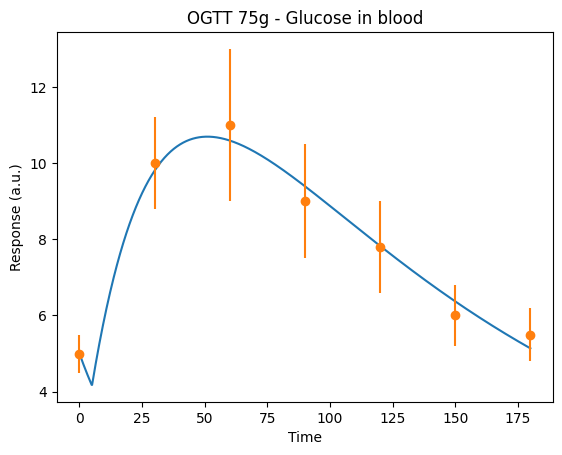

In [8]:
theta = [k1_slider.value, k2_slider.value, k3_slider.value]

bounds = Bounds([np.log(1e-6)]*len(theta), [np.log(1e6)]*len(theta))
theta0_log = np.log(theta)
result = differential_evolution(cost_log, bounds, x0 = theta0_log, args=(sims_simple,DATA), maxiter=1000, disp=True)
result['x'] = np.exp(result['x']).tolist()
theta = result["x"]
print(f"theta = {theta}")

# theta= [0.02116556130636561, 0.05065273217459981, 0.00013656522618978048, 29026.238494314388, 756.5170187028791] # A known solution from the optimization above
simulate_and_plot(sims_simple, theta)

In this first version, glucose is simply being taken up, but we know that this is due to insulin being secreted. Lets include insulin!

## Step 2: Implement insulin into the model

![glucose-insulin](assets/glucose-insulin.svg)

Now, revise the model from before with the new reactions. You have been provided the foundation of the model below. Please do not change the order of the states, parameters or variables. 

In [9]:
with open("models/first_insulin.txt", "w") as f:
    f.write("""
########## NAME
first_insulin

########## METADATA
timeunit = m

########## MACROS

########## STATES
ddt_glucose_OGTT = -v1
ddt_glucose_stomach = v1 - v2
ddt_glucose_blood = v2 -v3
ddt_insulin_blood = v4 -v5

glucose_OGTT(0) = 0 // mg
glucose_stomach(0) = 0
glucose_blood(0) = 5 // mmol/L
insulin_blood(0) = 100 // pmol/L

########## PARAMETERS
k1 = 1 //values does not mean anything, overwritten later
k2 = 1
k3 = 1
k4 = 1
k5 = 1

########## VARIABLES
v1 = k1 * glucose_OGTT
v2 = k2 * glucose_stomach
v3 = k3 * glucose_blood*insulin_blood
v4 = k4 * glucose_blood
v5 = k5 * insulin_blood

########## FUNCTIONS

########## EVENTS
glucose_event = glucose_input>0, glucose_OGTT, glucose_OGTT+glucose_input

########## OUTPUTS

########## INPUTS
glucose_input = glucose_input @ 0

########## FEATURES
Glucose in blood = glucose_blood
Insulin in blood = insulin_blood

""")

In [10]:
# Install/load the model (note that the notebook must be restarted if the model file is updated)
sund.installModel('models/first_insulin.txt')
First_insulin = sund.importModel('first_insulin')
first_insulin = First_insulin() # get the object from the model class

theta0= [0.02, 0.05, 0.0001, 20000, 850] 

feature_indices = {k:i for i,k in enumerate(first_insulin.featurenames)}

sims_first_insulin = {}
sims_first_insulin["OGTT 75g"] = setup_simulation(first_insulin, glucose = DATA["OGTT 75g"]["input"]["glucose"])

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\wls\.pyenv\pyenv-win\versions\3.12.3\Lib\logging\__init__.py", line 1163, in emit
    stream.write(msg + self.terminator)
ValueError: I/O operation on closed file.
Call stack:
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "c:\Users\wls\.virtualenvs\monocyte_modelling_example-vs5j9PVs\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "c:\Users\wls\.virtualenvs\monocyte_modelling_example-vs5j9PVs\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "c:\Users\wls\.virtualenvs\monocyte_modelling_example-vs5j9PVs\Lib\site-packages\ipykernel\kernelapp.py", line 739, in start
    self.io_loop.start()
  File "c:\Users\wls\.virtualenvs\monocyte_modelling_example-vs5j9PVs\Lib\site-packages\tornado\platform\asyncio.py", line 205, in start
    self.asyncio_loo

Model 'first_insulin' succesfully installed.


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\wls\.pyenv\pyenv-win\versions\3.12.3\Lib\logging\__init__.py", line 1163, in emit
    stream.write(msg + self.terminator)
ValueError: I/O operation on closed file.
Call stack:
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "c:\Users\wls\.virtualenvs\monocyte_modelling_example-vs5j9PVs\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "c:\Users\wls\.virtualenvs\monocyte_modelling_example-vs5j9PVs\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "c:\Users\wls\.virtualenvs\monocyte_modelling_example-vs5j9PVs\Lib\site-packages\ipykernel\kernelapp.py", line 739, in start
    self.io_loop.start()
  File "c:\Users\wls\.virtualenvs\monocyte_modelling_example-vs5j9PVs\Lib\site-packages\tornado\platform\asyncio.py", line 205, in start
    self.asyncio_loo

In [11]:
# Setup sliders

k1_slider = widgets.FloatSlider(min=0.001, max=0.1, step=0.0001, value=theta0[0])
k2_slider = widgets.FloatSlider(min=0.001, max=1, step=0.001, value=theta0[1])
k3_slider = widgets.FloatSlider(min=0.00001, max=0.001, step=0.00001, value=theta0[2])
k4_slider = widgets.FloatSlider(min=1, max=50000, step=1, value=theta0[3])
k5_slider = widgets.FloatSlider(min=1, max=1000, step=1, value=theta0[4])

# Simulate and plot
time = np.linspace(0, 180, 1000)
@interact(k1=k1_slider, k2=k2_slider, k3=k3_slider, k4=k4_slider, k5=k5_slider)
def handle_input(k1=0.2, k2=0.1, k3=0.2, k4=0.1, k5=0.05):
    simulate_and_plot(sims_first_insulin, [k1,k2, k3, k4, k5])

interactive(children=(FloatSlider(value=0.02, description='k1', max=0.1, min=0.001, step=0.0001), FloatSlider(…

differential_evolution step 1: f(x)= 87.54507148371525
differential_evolution step 2: f(x)= 87.54507148371525
differential_evolution step 3: f(x)= 87.54507148371525
differential_evolution step 4: f(x)= 64.82121959712443
differential_evolution step 5: f(x)= 64.82121959712443
differential_evolution step 6: f(x)= 64.82121959712443
differential_evolution step 7: f(x)= 64.82121959712443
differential_evolution step 8: f(x)= 64.82121959712443
differential_evolution step 9: f(x)= 64.82121959712443
differential_evolution step 10: f(x)= 43.3834958818272
differential_evolution step 11: f(x)= 43.3834958818272
differential_evolution step 12: f(x)= 43.3834958818272
differential_evolution step 13: f(x)= 43.3834958818272
differential_evolution step 14: f(x)= 43.3834958818272
differential_evolution step 15: f(x)= 43.3834958818272
differential_evolution step 16: f(x)= 38.08118313713462
differential_evolution step 17: f(x)= 38.08118313713462
differential_evolution step 18: f(x)= 38.08118313713462
differe

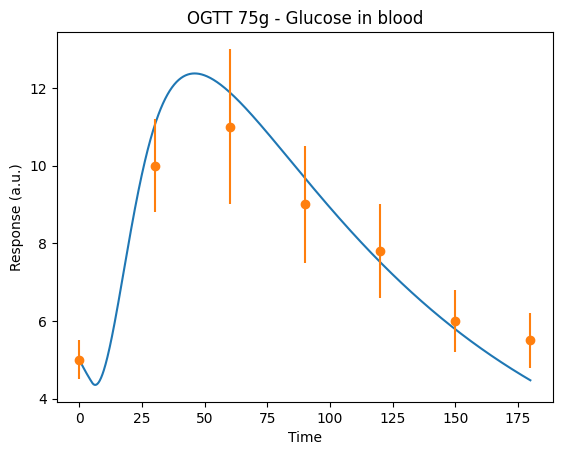

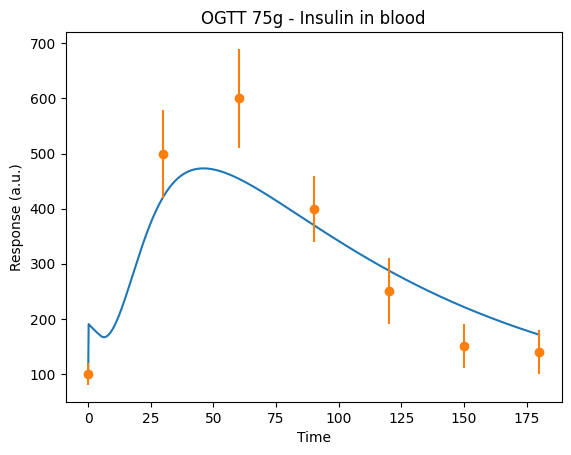

In [12]:
# Optimize the parameter values (only to get a possible solution, students will use sliders)

theta = [k1_slider.value, k2_slider.value, k3_slider.value, k4_slider.value, k5_slider.value]

bounds = Bounds([np.log(1e-6)]*len(theta), [np.log(1e6)]*len(theta))
theta0_log = np.log(theta)
result = differential_evolution(cost_log, bounds, x0 = theta0_log, args=(sims_first_insulin,DATA), maxiter=1000, disp=True)
result['x'] = np.exp(result['x']).tolist()
theta = result["x"]
print(f"theta = {theta}")

# theta= [0.02116556130636561, 0.05065273217459981, 0.00013656522618978048, 29026.238494314388, 756.5170187028791] # A known solution from the optimization above
simulate_and_plot(sims_first_insulin, theta)


Looks rather good right? But doesnt it look like the insulin and glucose levels aren't flattening out? 

Use the model again, but simulate a longer response. Is the behavior reasonable? 

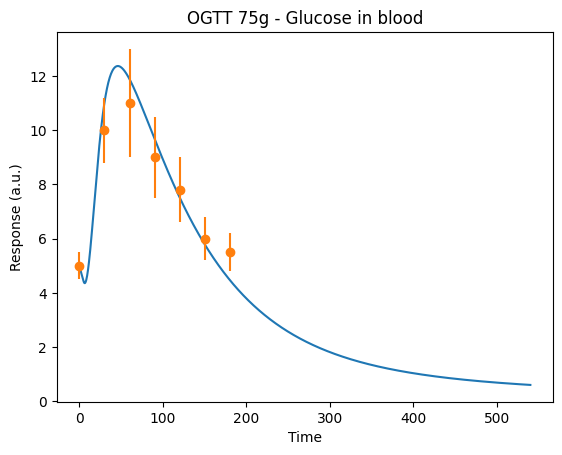

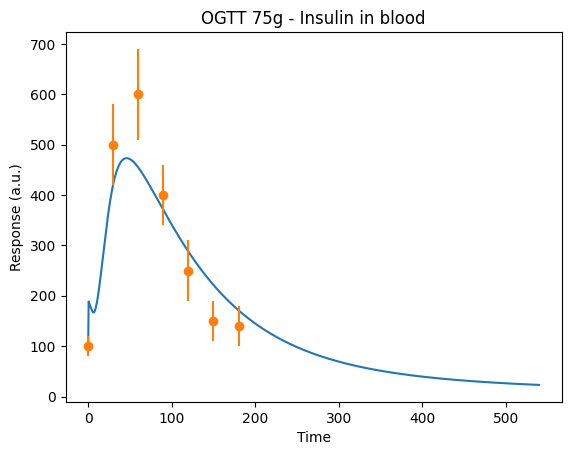

In [13]:
time_long = np.linspace(0, 540, 1000)
simulate_and_plot(sims_first_insulin, theta, time = time_long)

## Step 3: Expanding the model with a simple glucose storage/release in the liver
We need to introduce a basal level of glucose, primarily from the liver. And we have now also measured some additional datapoints at a longer time scale.

![glucose-insulin-liver](assets/glucose-insulin-liver.svg)

Again, revise the model equations to correspond to the revised hypothesis

*Note that the reaction Glucose_liver -> Glucose_blood should be saturated with respect to Glucose_liver.*

*Also note that the reaction is inhibited by Glucose blood. In this case, we multiply the reaction with the following inhibition factor:*

```
1/(1+k6inhib*glucose_blood)
```



In [14]:
with open("models/pancreas_liver.txt", "w") as f:
    f.write("""
########## NAME
pancreas_liver

########## METADATA
timeunit = m

########## MACROS

########## STATES
ddt_glucose_OGTT = -v1
ddt_glucose_stomach = v1 - v2
ddt_glucose_blood = v2 -v3 + v6
ddt_insulin_blood = v4 -v5
ddt_glucose_liver = v3 - v6

glucose_OGTT(0) = 0 // mg
glucose_stomach(0) = 0
glucose_blood(0) = 5 // mmol/L
insulin_blood(0) = 100 // pmol/L
glucose_liver(0) = 1000

########## PARAMETERS
k1 = 1 //values does not mean anything, overwritten later
k2 = 1
k3 = 1
k4 = 1
k4a = 1
k5 = 1
k6 = 1
k6inhib =1
kM = 1

########## VARIABLES
v1 = k1 * glucose_OGTT
v2 = k2 * glucose_stomach
v3 = k3 * glucose_blood*insulin_blood
v4 = k4 * glucose_blood + k4a
v5 = k5 * insulin_blood
v6 = k6 * (glucose_liver/(kM+glucose_liver))/(1+k6inhib*glucose_blood)

########## FUNCTIONS

########## EVENTS
glucose_event = glucose_input>0, glucose_OGTT, glucose_OGTT+glucose_input

########## OUTPUTS

########## INPUTS
glucose_input = glucose_input @ 0

########## FEATURES
Glucose in blood = glucose_blood
Insulin in blood = insulin_blood
""")

In [15]:
# Install/load the model (note that the notebook must be restarted if the model file is updated)
sund.installModel('models/pancreas_liver.txt')
Pancreas_liver = sund.importModel('pancreas_liver')
pancreas_liver = Pancreas_liver() # get the object from the model class

theta0 = [0.031, 0.03, 0.00017, 1100, 0.01, 38, 65650, 24000, 1]

feature_indices = {k:i for i,k in enumerate(pancreas_liver.featurenames)}

sims_pancreas_liver = {}
sims_pancreas_liver["OGTT 75g longterm"] = setup_simulation(pancreas_liver, glucose = DATA_LONGTERM["OGTT 75g longterm"]["input"]["glucose"])

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\wls\.pyenv\pyenv-win\versions\3.12.3\Lib\logging\__init__.py", line 1163, in emit
    stream.write(msg + self.terminator)
ValueError: I/O operation on closed file.
Call stack:
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "c:\Users\wls\.virtualenvs\monocyte_modelling_example-vs5j9PVs\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "c:\Users\wls\.virtualenvs\monocyte_modelling_example-vs5j9PVs\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "c:\Users\wls\.virtualenvs\monocyte_modelling_example-vs5j9PVs\Lib\site-packages\ipykernel\kernelapp.py", line 739, in start
    self.io_loop.start()
  File "c:\Users\wls\.virtualenvs\monocyte_modelling_example-vs5j9PVs\Lib\site-packages\tornado\platform\asyncio.py", line 205, in start
    self.asyncio_loo

Model 'pancreas_liver' succesfully installed.


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\wls\.pyenv\pyenv-win\versions\3.12.3\Lib\logging\__init__.py", line 1163, in emit
    stream.write(msg + self.terminator)
ValueError: I/O operation on closed file.
Call stack:
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "c:\Users\wls\.virtualenvs\monocyte_modelling_example-vs5j9PVs\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "c:\Users\wls\.virtualenvs\monocyte_modelling_example-vs5j9PVs\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "c:\Users\wls\.virtualenvs\monocyte_modelling_example-vs5j9PVs\Lib\site-packages\ipykernel\kernelapp.py", line 739, in start
    self.io_loop.start()
  File "c:\Users\wls\.virtualenvs\monocyte_modelling_example-vs5j9PVs\Lib\site-packages\tornado\platform\asyncio.py", line 205, in start
    self.asyncio_loo

In [16]:
k1_slider = widgets.FloatSlider(min=0.00001, max=1, step=0.0001, value=theta0[0])
k2_slider = widgets.FloatSlider(min=0.00001, max=1, step=0.001, value=theta0[1])
k3_slider = widgets.FloatSlider(min=0.00001, max=0.001, step=0.00001, value=theta0[2])
k4_slider = widgets.FloatSlider(min=1, max=10000, step=1, value=theta0[3])
k4a_slider = widgets.FloatSlider(min=0.0001, max=10, step=0.001, value= theta0[4])
k5_slider = widgets.FloatSlider(min=1, max=100, step=0.1, value=theta0[5])
k6_slider = widgets.FloatSlider(min=1, max=100000, step=1, value=theta0[6])
k6inhib_slider = widgets.FloatSlider(min=1, max=100000, step=1, value=theta0[7])
kM_slider = widgets.FloatSlider(min=0.01, max=1, step=0.001, value=theta0[8])

# Simulate and plot
time = np.linspace(0, 180, 1000)
@interact(k1=k1_slider, k2=k2_slider, k3=k3_slider, k4=k4_slider, k4a=k4a_slider, k5=k5_slider, k6=k6_slider, k6inhib=k6inhib_slider, kM=kM_slider)
def handle_input(k1=0.2, k2=0.1, k3=0.2, k4=0.1, k4a=100, k5=0.05, k6=2.5e-6, k6inhib=150, kM=0.00076):
    simulate_and_plot(sims_pancreas_liver, [k1,k2, k3, k4, k4a, k5, k6, k6inhib, kM], data = DATA_LONGTERM)
    plt.show()

interactive(children=(FloatSlider(value=0.031, description='k1', max=1.0, min=1e-05, step=0.0001), FloatSlider…

differential_evolution step 1: f(x)= 203.30272850981302
differential_evolution step 2: f(x)= 129.23540129334023
differential_evolution step 3: f(x)= 129.23540129334023
differential_evolution step 4: f(x)= 129.23540129334023
differential_evolution step 5: f(x)= 129.23540129334023
differential_evolution step 6: f(x)= 110.16500693257863
differential_evolution step 7: f(x)= 110.16500693257863
differential_evolution step 8: f(x)= 110.16500693257863
differential_evolution step 9: f(x)= 110.16500693257863
differential_evolution step 10: f(x)= 110.16500693257863
differential_evolution step 11: f(x)= 110.16500693257863
differential_evolution step 12: f(x)= 110.16500693257863
differential_evolution step 13: f(x)= 110.16500693257863
differential_evolution step 14: f(x)= 106.33405214738113
differential_evolution step 15: f(x)= 106.33405214738113
differential_evolution step 16: f(x)= 106.33405214738113
differential_evolution step 17: f(x)= 106.33405214738113
differential_evolution step 18: f(x)= 10

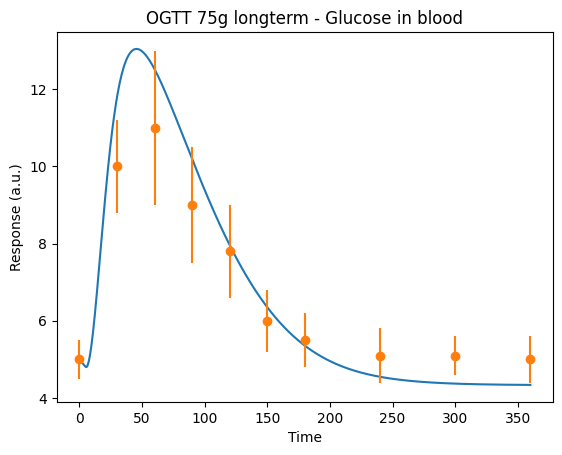

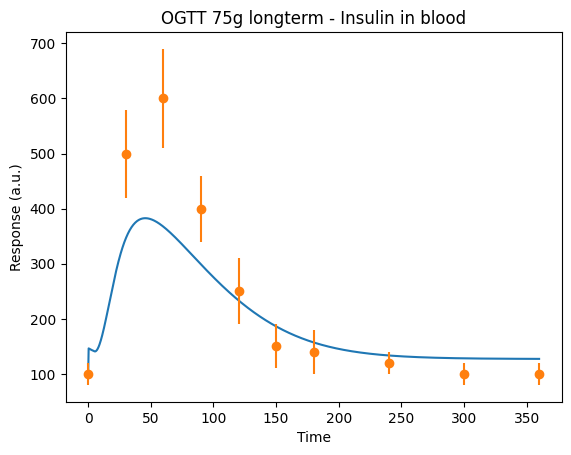

In [17]:
theta = [k1_slider.value, k2_slider.value, k3_slider.value, k4_slider.value, k4a_slider.value, k5_slider.value, k6_slider.value, k6inhib_slider.value, kM_slider.value]

bounds = Bounds([np.log(1e-6)]*len(theta), [np.log(1e6)]*len(theta))
theta_log = np.log(theta)
result = differential_evolution(cost_log, bounds, x0 = theta_log, args=(sims_pancreas_liver,DATA_LONGTERM), maxiter=1000, disp=True)
result['x'] = np.exp(result['x']).tolist()
theta = result['x']
print(f"theta = {theta}")

# theta = [0.03350162272105301, 0.03200333343006843, 0.00017882698734739214, 1132.4142382444488, 0.01184902326283909, 38.44343552658225, 10141.658880673678, 23970.97067261919, 0.9434301987204373]
simulate_and_plot(sims_pancreas_liver, theta, data = DATA_LONGTERM)



Did the model fit with data good enough? 

## Step 4: Testing with alternative kinetics
The above model did not work so good. One reason is probably the nonlinear relationship between glucose and insulin production (insulin is mostly produced when glucose levels are high, typically >6). We can try with a nonlinear kinetic.

Try with hill kinetics on the reaction `pancreas -> insulin_blood` (saturated with respect to Glucose_blood) to only have insulin production at glucose levels above a certain threshold

```c
v4 = k4 * glucose_blood^n/(kMglu^n + glucose_blood^n) + k4a
```

In [20]:
with open("models/pancreas_liver_hill.txt", "w") as f:
    f.write("""
########## NAME
pancreas_liver_hill

########## METADATA
timeunit = m

########## MACROS

########## STATES
ddt_glucose_OGTT = -v1
ddt_glucose_stomach = v1 - v2
ddt_glucose_blood = v2 - v3 + v6
ddt_insulin_blood = v4 -v5
ddt_glucose_liver = v3 - v6

glucose_OGTT(0) = 0 // mg
glucose_stomach(0) = 0
glucose_blood(0) = 5 // mmol/L
insulin_blood(0) = 100 // pmol/L
glucose_liver(0) = 1000

########## PARAMETERS
k1 = 1 //values does not mean anything, overwritten later
k2 = 1
k3 = 1
k4 = 1
k4a = 1
k5 = 1
k6 = 1
k6inhib =1
kM = 1
kMglu = 1
n = 1

########## VARIABLES
v1 = k1 * glucose_OGTT
v2 = k2 * glucose_stomach
v3 = k3 * glucose_blood*insulin_blood
v4 = k4 * glucose_blood^n/(kMglu^n + glucose_blood^n) + k4a
v5 = k5 * insulin_blood
v6 = k6 * (glucose_liver/(kM+glucose_liver))/(1+k6inhib*glucose_blood)

########## FUNCTIONS

########## EVENTS
glucose_event = glucose_input>0, glucose_OGTT, glucose_OGTT+glucose_input

########## OUTPUTS

########## INPUTS
glucose_input = glucose_input @ 0

########## FEATURES
Glucose in blood = glucose_blood
Insulin in blood = insulin_blood
""")

In [21]:
sund.installModel('models/pancreas_liver_hill.txt')
Pancreas_liver_hill = sund.importModel('pancreas_liver_hill')
pancreas_liver_hill = Pancreas_liver_hill() # get the object from the model class

theta0 = [0.035, 0.035, 1e-4, 20000, 380, 45, 0.5, 5, 0.05, 8.5, 3.5]
feature_indices = {k:i for i,k in enumerate(pancreas_liver_hill.featurenames)}

sims_pancreas_liver_hill = {}
sims_pancreas_liver_hill["OGTT 75g longterm"] = setup_simulation(pancreas_liver_hill, glucose = DATA_LONGTERM["OGTT 75g longterm"]["input"]["glucose"])


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\wls\.pyenv\pyenv-win\versions\3.12.3\Lib\logging\__init__.py", line 1163, in emit
    stream.write(msg + self.terminator)
ValueError: I/O operation on closed file.
Call stack:
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "c:\Users\wls\.virtualenvs\monocyte_modelling_example-vs5j9PVs\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "c:\Users\wls\.virtualenvs\monocyte_modelling_example-vs5j9PVs\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "c:\Users\wls\.virtualenvs\monocyte_modelling_example-vs5j9PVs\Lib\site-packages\ipykernel\kernelapp.py", line 739, in start
    self.io_loop.start()
  File "c:\Users\wls\.virtualenvs\monocyte_modelling_example-vs5j9PVs\Lib\site-packages\tornado\platform\asyncio.py", line 205, in start
    self.asyncio_loo

Model 'pancreas_liver_hill' succesfully installed.


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\wls\.pyenv\pyenv-win\versions\3.12.3\Lib\logging\__init__.py", line 1163, in emit
    stream.write(msg + self.terminator)
ValueError: I/O operation on closed file.
Call stack:
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "c:\Users\wls\.virtualenvs\monocyte_modelling_example-vs5j9PVs\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "c:\Users\wls\.virtualenvs\monocyte_modelling_example-vs5j9PVs\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "c:\Users\wls\.virtualenvs\monocyte_modelling_example-vs5j9PVs\Lib\site-packages\ipykernel\kernelapp.py", line 739, in start
    self.io_loop.start()
  File "c:\Users\wls\.virtualenvs\monocyte_modelling_example-vs5j9PVs\Lib\site-packages\tornado\platform\asyncio.py", line 205, in start
    self.asyncio_loo

In [22]:
k1_slider = widgets.FloatSlider(min=0.00001, max=0.1, step=0.0001, value=theta0[0])
k2_slider = widgets.FloatSlider(min=0.00001, max=0.1, step=0.001, value=theta0[1])
k3_slider = widgets.FloatSlider(min=0.00001, max=0.001, step=0.00001, value=theta0[2])
k4_slider = widgets.FloatSlider(min=0.001, max=100000, step=1, value=theta0[3])
k4a_slider = widgets.FloatSlider(min=0.1, max=1000, step=1, value=theta0[4])
k5_slider = widgets.FloatSlider(min=0.01, max=1000, step=0.1, value=theta0[5])
k7_slider = widgets.FloatSlider(min=0.001, max=1, step=0.001, value=theta0[6])
k7inhib_slider = widgets.FloatSlider(min=0.001, max=10, step=0.001, value=theta0[7])
kM_slider = widgets.FloatSlider(min=0.0001, max=0.1, step=0.0001, value=theta0[8])
kMglu_slider = widgets.FloatSlider(min=2, max=10, step=0.01, value=theta0[9])
n_slider = widgets.FloatSlider(min=0.5, max=4, step=0.01, value=theta0[10])

# Simulate and plot
@interact(k1=k1_slider, k2=k2_slider, k3=k3_slider, k4=k4_slider, k4a=k4a_slider, k5=k5_slider, k7=k7_slider, k7inhib=k7inhib_slider, kM=kM_slider, kMglu=kMglu_slider, n=n_slider)
def handle_input(k1=0.2, k2=0.1, k3=0.2, k4=0.1, k4a=100, k5=0.05, k6=65, k6inhib=150, kM=0.00076, kMglu=8.5, n=3.7):
    simulate_and_plot(sims_pancreas_liver_hill, [k1,k2, k3, k4, k4a, k5, k6, k6inhib, kM, kMglu, n], data = DATA_LONGTERM)
    plt.show()

interactive(children=(FloatSlider(value=0.035, description='k1', max=0.1, min=1e-05, step=0.0001), FloatSlider…

differential_evolution step 1: f(x)= 82.99677549102945
differential_evolution step 2: f(x)= 82.99677549102945
differential_evolution step 3: f(x)= 82.99677549102945
differential_evolution step 4: f(x)= 82.99677549102945
differential_evolution step 5: f(x)= 82.99677549102945
differential_evolution step 6: f(x)= 82.99677549102945
differential_evolution step 7: f(x)= 82.99677549102945
differential_evolution step 8: f(x)= 82.99677549102945
differential_evolution step 9: f(x)= 82.99677549102945
differential_evolution step 10: f(x)= 82.99677549102945
differential_evolution step 11: f(x)= 82.99677549102945
differential_evolution step 12: f(x)= 82.99677549102945
differential_evolution step 13: f(x)= 82.99677549102945
differential_evolution step 14: f(x)= 82.99677549102945
differential_evolution step 15: f(x)= 82.99677549102945
differential_evolution step 16: f(x)= 82.99677549102945
differential_evolution step 17: f(x)= 82.99677549102945
differential_evolution step 18: f(x)= 82.99677549102945
d

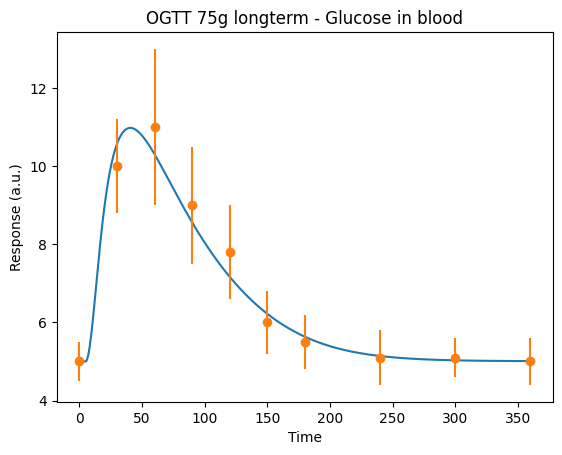

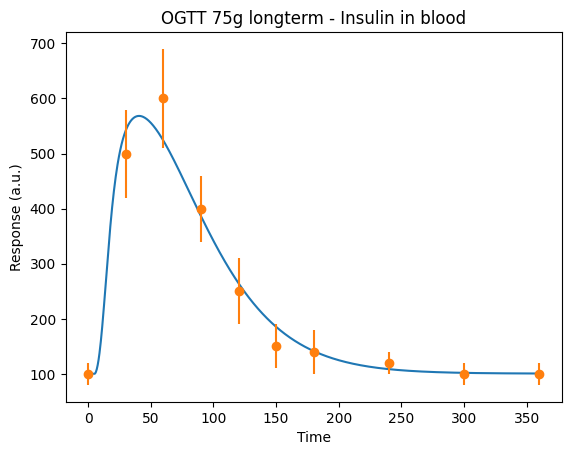

In [23]:
# Optimize the parameter values for the hill model

theta = [k1_slider.value, k2_slider.value, k3_slider.value, k4_slider.value, k4a_slider.value, k5_slider.value, k7_slider.value, k7inhib_slider.value, kM_slider.value, kMglu_slider.value, n_slider.value]

lb = np.log([1e-6]*len(theta))
ub = np.log([1e6]*len(theta))
lb[-1] = 0.5
ub[-1] = 4
bounds = Bounds(lb, ub)

theta0_log = np.log(theta)
theta0_log[-1] = theta0[-1]

def cost_log_hill(p, simulations, data):
    p[:-1] = np.exp(p[:-1])
    return cost_f(p, simulations, data.copy())

result = differential_evolution(cost_log_hill, bounds, x0 = theta0_log, args=(sims_pancreas_liver_hill,DATA_LONGTERM), maxiter=1000, disp=True)
result['x'][:-1] = np.exp(result['x'][:-1]).tolist()
theta = result["x"]


# theta = [3.53579878e-02, 3.29095486e-02, 1.54614753e-04, 1.46740186e+05, 1.24116030e+03,
#  1.73682833e+02, 6.88210529e-01, 1.56684206e+00,
#  8.46759379e-01, 9.07592697e+00, 3.49757932e+00] # Known good solution
simulate_and_plot(sims_pancreas_liver_hill, theta, data = DATA_LONGTERM)

print(f"theta = {theta}")

## Making predictions
Now that we have a model which is acting reasonably, we can use it make predictions

### Estimating the increased insulin production in Type 2 diabetes

Now, we have this hypothetical scenario, where the person have partial insulin resistance (~50% less sensitivity). How much would you need to increase the insulin secretion to bring the glucose level down to normal amounts? Can you find any combinations of parameter values which give normal insulin levels? 

In [24]:
k4_slider = widgets.FloatSlider(min=0.001, max=1e6, step=1, value=theta[3])
k4a_slider = widgets.FloatSlider(min=0.001, max=10000, step=1, value=theta[4])
kMglu_slider = widgets.FloatSlider(min=2, max=10, step=0.01, value=theta[9])
n_slider = widgets.FloatSlider(min=0.5, max=4, step=0.01, value=theta[10])

# Simulate and plot
@interact(k4=k4_slider, k4a=k4a_slider, kMglu=kMglu_slider, n=n_slider)
def handle_input(k4=0.1, k4a=100, kMglu=8.5, n=3.7):
    p = theta.copy()
    p[2] = p[2]/2 # k3, which is glucose induced insulin secretion
    p[3] = k4
    p[4] = k4a
    p[9] = kMglu
    p[10] = n
    
    simulate_and_plot(sims_pancreas_liver_hill, p, data = DATA_LONGTERM)
    plt.show()

interactive(children=(FloatSlider(value=351212.12179301603, description='k4', max=1000000.0, min=0.001, step=1…

### Maintaining glucose levels with exercise

Given your manual selection to give improved glucose dynamics, can you improve the agreement by introducing exercise? Can you reduce the amount of insulin needed to be secreted? 

First, we need to update the model to have an additional reaction (v7) which clears the glucose based on the exercise

In [25]:
with open("models/pancreas_liver_exercise.txt", "w") as f:
    f.write("""
########## NAME
pancreas_liver_exercise

########## METADATA
timeunit = m

########## MACROS

########## STATES
ddt_glucose_OGTT = -v1
ddt_glucose_stomach = v1 - v2
ddt_glucose_blood = v2 - v3 + v6 -v7

ddt_insulin_blood = v4 -v5

ddt_glucose_liver = v3 - v6

glucose_OGTT(0) = 0 // mg
glucose_stomach(0) = 0
glucose_blood(0) = 5 // mmol/L
insulin_blood(0) = 100 // pmol/L
glucose_liver(0) = 1000

########## PARAMETERS
k1 = 1 //values does not mean anything, overwritten later
k2 = 1
k3 = 1
k4 = 1
k4a = 1
k5 = 1
k6 = 1
k6inhib =1
kM = 1
kMglu = 1

kexercise = 0
n = 1

########## VARIABLES
v1 = k1 * glucose_OGTT
v2 = k2 * glucose_stomach
v3 = k3 * glucose_blood*insulin_blood
v4 = k4 * glucose_blood^n/(kMglu^n + glucose_blood^n) + k4a
v5 = k5 * insulin_blood
v6 = k6 * (glucose_liver/(kM+glucose_liver))/(1+k6inhib*glucose_blood)
v7 = kexercise * glucose_blood

########## FUNCTIONS

########## EVENTS
glucose_event = glucose_input>0, glucose_OGTT, glucose_OGTT+glucose_input

########## OUTPUTS

########## INPUTS
glucose_input = glucose_input @ 0

########## FEATURES
Glucose in blood = glucose_blood
Insulin in blood = insulin_blood
""")

In [26]:
# Setup simulations for the model which includes exercise
sund.installModel('models/pancreas_liver_exercise.txt')
Pancreas_liver_exercise = sund.importModel('pancreas_liver_exercise')
pancreas_liver_exercise = Pancreas_liver_exercise() # get the object from the model class

sims_pancreas_liver_exercise = {}
sims_pancreas_liver_exercise["OGTT 75g longterm"] = setup_simulation(pancreas_liver_exercise, glucose = DATA_LONGTERM["OGTT 75g longterm"]["input"]["glucose"])

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\wls\.pyenv\pyenv-win\versions\3.12.3\Lib\logging\__init__.py", line 1163, in emit
    stream.write(msg + self.terminator)
ValueError: I/O operation on closed file.
Call stack:
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "c:\Users\wls\.virtualenvs\monocyte_modelling_example-vs5j9PVs\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "c:\Users\wls\.virtualenvs\monocyte_modelling_example-vs5j9PVs\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "c:\Users\wls\.virtualenvs\monocyte_modelling_example-vs5j9PVs\Lib\site-packages\ipykernel\kernelapp.py", line 739, in start
    self.io_loop.start()
  File "c:\Users\wls\.virtualenvs\monocyte_modelling_example-vs5j9PVs\Lib\site-packages\tornado\platform\asyncio.py", line 205, in start
    self.asyncio_loo

Model 'pancreas_liver_exercise' succesfully installed.


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\wls\.pyenv\pyenv-win\versions\3.12.3\Lib\logging\__init__.py", line 1163, in emit
    stream.write(msg + self.terminator)
ValueError: I/O operation on closed file.
Call stack:
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "c:\Users\wls\.virtualenvs\monocyte_modelling_example-vs5j9PVs\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "c:\Users\wls\.virtualenvs\monocyte_modelling_example-vs5j9PVs\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "c:\Users\wls\.virtualenvs\monocyte_modelling_example-vs5j9PVs\Lib\site-packages\ipykernel\kernelapp.py", line 739, in start
    self.io_loop.start()
  File "c:\Users\wls\.virtualenvs\monocyte_modelling_example-vs5j9PVs\Lib\site-packages\tornado\platform\asyncio.py", line 205, in start
    self.asyncio_loo

In [27]:
theta_exercise = theta.tolist()
theta_exercise[2] = theta_exercise[2]/2
theta_exercise[3] = k4_slider.value
theta_exercise[4] = k4a_slider.value
theta_exercise[9] = kMglu_slider.value
theta_exercise[10] = n_slider.value
theta_exercise.insert(-2, 0)

k4_slider_2 = widgets.FloatSlider(min=0.001, max=1e6, step=1, value=k4_slider.value)
k4a_slider_2 = widgets.FloatSlider(min=0.001, max=10000, step=1, value=k4a_slider.value)
kMglu_slider_2 = widgets.FloatSlider(min=2, max=10, step=0.01, value=kMglu_slider.value)
n_slider_2 = widgets.FloatSlider(min=0.5, max=4, step=0.01, value=n_slider.value)


exercise_slider = widgets.FloatSlider(min=0.0001, max=0.1, step=0.00001, value=0)

# Simulate and plot
@interact(k4=k4_slider_2, k4a=k4a_slider_2, kMglu=kMglu_slider_2, n=n_slider_2, exercise=exercise_slider)
def handle_input(k4=0.1, k4a=100, kMglu=8.5, n=3.7, exercise=0):
    p = theta_exercise.copy()
    p[3] = k4
    p[4] = k4a
    p[9] = kMglu
    p[10] = exercise
    p[11] = n
    
    simulate_and_plot(sims_pancreas_liver_exercise, p, data = DATA_LONGTERM)
    plt.show()

interactive(children=(FloatSlider(value=351212.00100000005, description='k4', max=1000000.0, min=0.001, step=1…

### Simulating Type 1 diabetes

In type 1 diabetes, insulin production is severly decreased or fully stopped. We can simulate this scenario by setting the corresponding insulin secretion parameters to 0. 
Can exercise alone maintain the glucose levels? 

In [28]:
theta_exercise = theta.tolist()
theta_exercise[3] = 0 
theta_exercise[4] = 0
theta_exercise.insert(-2, 0)

exercise_slider_2 = widgets.FloatSlider(min=0.0001, max=0.1, step=0.00001, value=0)

ic = pancreas_liver_exercise.statevalues.copy()
ic[-2] = 0

# Simulate and plot
@interact(exercise=exercise_slider)
def handle_input(exercise=0):
    p = theta_exercise.copy()
    p[10] = exercise
    
    simulate_and_plot(sims_pancreas_liver_exercise, p, ic=ic, data = DATA_LONGTERM)
    plt.show()

interactive(children=(FloatSlider(value=0.0001, description='exercise', max=0.1, min=0.0001, step=1e-05), Outp…

This marks the end of the exercise! I hope you have seen the usefulness of dynamic ODE models!